# Phase 1 -  Data Wrangling 
###  First we need to read and explore each dataset, find any "bad formatation" or null value.


In [1]:
import pandas as pd
import os
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

In [2]:
path = "./"
files = [file for file in os.listdir(path) if file.startswith('dublinbike-historical-data-2023') ] # filtere only historical data files

all_hist = pd.DataFrame()

for file in files:
    current_month = pd.read_csv(path+"/"+file)
    all_hist = pd.concat([all_hist, current_month])

all_hist.shape


(1852356, 11)

In [3]:
all_hist.head()

,STATION ID,TIME,LAST UPDATED,NAME,BIKE_STANDS,AVAILABLE_BIKE_STANDS,AVAILABLE_BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
0,1,2023-01-01 00:00:03,2022-12-31 23:59:39,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,-6.26250
1,2,2023-01-01 00:00:03,2022-12-31 23:57:48,BLESSINGTON STREET,20,18,2,OPEN,Blessington Street,53.3568,-6.26814
2,3,2023-01-01 00:00:03,2022-12-31 23:57:10,BOLTON STREET,20,9,11,OPEN,Bolton Street,53.3512,-6.26986
3,4,2023-01-01 00:00:03,2022-12-31 23:51:39,GREEK STREET,20,8,12,OPEN,Greek Street,53.3469,-6.27298
4,5,2023-01-01 00:00:03,2022-12-31 23:58:28,CHARLEMONT PLACE,40,16,24,OPEN,Charlemont Street,53.3307,-6.26018


In [56]:
all_hist.isnull().sum()

STATION ID               0
TIME                     0
LAST UPDATED             0
NAME                     0
BIKE_STANDS              0
AVAILABLE_BIKE_STANDS    0
AVAILABLE_BIKES          0
STATUS                   0
ADDRESS                  0
LATITUDE                 0
LONGITUDE                0
dtype: int64

In [4]:
all_hist['STATION ID'].nunique()

115

In [3]:
bike_stations = all_hist.drop_duplicates(subset=["STATION ID"])
bike_stations.head()

,STATION ID,TIME,LAST UPDATED,NAME,BIKE_STANDS,AVAILABLE_BIKE_STANDS,AVAILABLE_BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
0,1,2023-01-01 00:00:03,2022-12-31 23:59:39,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,-6.26250
1,2,2023-01-01 00:00:03,2022-12-31 23:57:48,BLESSINGTON STREET,20,18,2,OPEN,Blessington Street,53.3568,-6.26814
2,3,2023-01-01 00:00:03,2022-12-31 23:57:10,BOLTON STREET,20,9,11,OPEN,Bolton Street,53.3512,-6.26986
3,4,2023-01-01 00:00:03,2022-12-31 23:51:39,GREEK STREET,20,8,12,OPEN,Greek Street,53.3469,-6.27298
4,5,2023-01-01 00:00:03,2022-12-31 23:58:28,CHARLEMONT PLACE,40,16,24,OPEN,Charlemont Street,53.3307,-6.26018


In [8]:
# Create a collor column  = Open = Green  Closed = Red
bike_stations['StationColor'] = bike_stations['STATUS'].apply(lambda x: 'True' if x == 'OPEN' else 'False')
bike_stations.head()

,STATION ID,TIME,LAST UPDATED,NAME,BIKE_STANDS,AVAILABLE_BIKE_STANDS,AVAILABLE_BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,StationColor
0,1,2023-01-01 00:00:03,2022-12-31 23:59:39,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,-6.26250,True
1,2,2023-01-01 00:00:03,2022-12-31 23:57:48,BLESSINGTON STREET,20,18,2,OPEN,Blessington Street,53.3568,-6.26814,True
2,3,2023-01-01 00:00:03,2022-12-31 23:57:10,BOLTON STREET,20,9,11,OPEN,Bolton Street,53.3512,-6.26986,True
3,4,2023-01-01 00:00:03,2022-12-31 23:51:39,GREEK STREET,20,8,12,OPEN,Greek Street,53.3469,-6.27298,True
4,5,2023-01-01 00:00:03,2022-12-31 23:58:28,CHARLEMONT PLACE,40,16,24,OPEN,Charlemont Street,53.3307,-6.26018,True


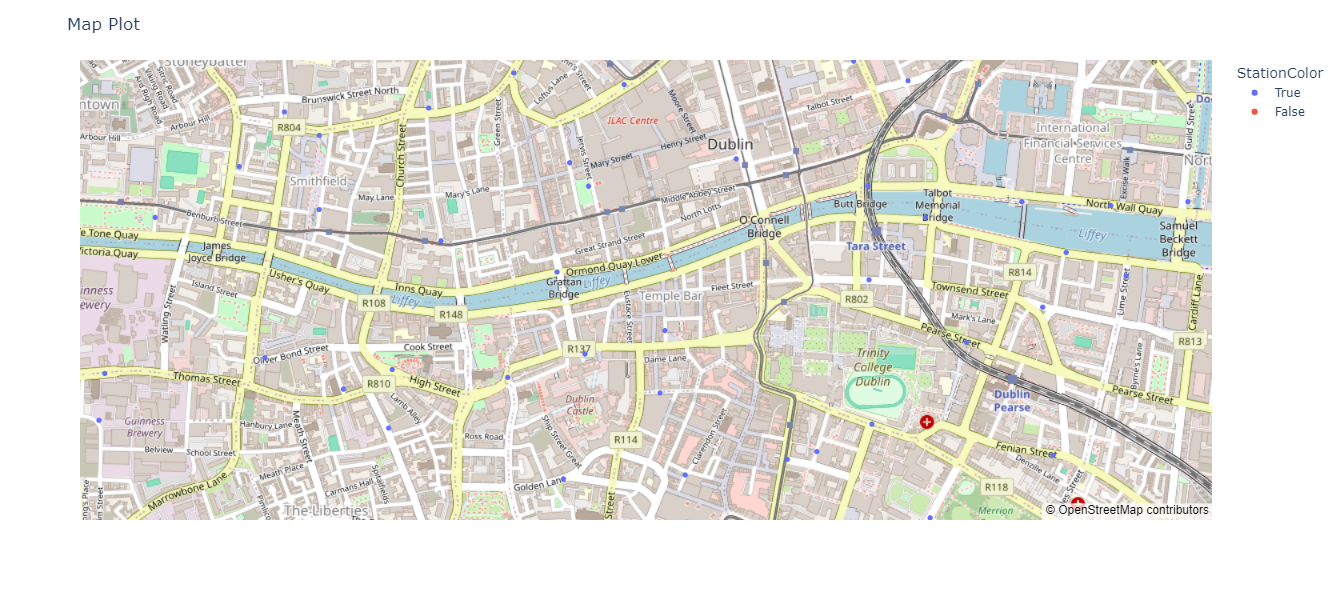

In [9]:
# Create map plot
fig = px.scatter_mapbox(bike_stations, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        #text="NAME", 
                        hover_name="NAME",
                        hover_data=["BIKE_STANDS","AVAILABLE_BIKE_STANDS"],
                        color="StationColor",  
                        
                        mapbox_style="open-street-map")
                        
                        

# Update layout for larger figure size
fig.update_layout(
    title="Map Plot",
    mapbox=dict(
        center=dict(lat=bike_stations["LATITUDE"].mean(), lon=bike_stations["LONGITUDE"].mean()),
        zoom=14
    ),
    autosize=False,
    width=800,  # Set the width of the figure
    height=600,  # Set the height of the figure
)

fig.show()